# Bacterial Ensemble Language Model

This notebook trains a language model on the ensemble of bacterial genomes assembled in the [Bacterial Ensemble 0 Data Processing](https://github.com/kheyer/Genomic-ULMFiT/blob/master/Bacteria/Bacterial%20Ensemble/Bacterial%20Ensemble%200%20Data%20Processing.ipynb) notebook. The language model trained is based on the AWD-LSTM architecture. the genomic input information is split into 5-mers with a stride of 2 bases between each 5-mer. The model is trained to take an input sequence of 5-mers and predict the next 5-mer. This allows us to train a model that learns the structure of genomic information in a totally unsupervised way.

The base of the language model (token embedding + LSTM layers) will then be used to initialize a classification model.

For more detail on how genomic data is processed and how these language models are trained, see the following notebooks:

[E. coli 1 Naive Model](https://github.com/kheyer/Genomic-ULMFiT/blob/master/Bacteria/E.%20Coli/E.%20coli%201%20Naive%20Model.ipynb)

[E. coli 2 Genomic Pretraining](https://github.com/kheyer/Genomic-ULMFiT/blob/master/Bacteria/E.%20Coli/E.%20coli%202%20Genomic%20Pretraining.ipynb)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.text import *
from Bio import Seq
from Bio.Seq import Seq
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import FeatureLocation, CompoundLocation
import networkx as nx

2022-07-29 16:34:40.437232: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-07-29 16:34:43.538880: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-07-29 16:34:43.540043: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-07-29 16:34:43.540217: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:07:00.0 name: NVIDIA GeForce GTX 1650 SUPER computeCapability: 7.5
coreClock: 1.755GHz coreCount: 20 deviceMemorySize: 4.00GiB deviceMemoryBandwidth: 178.84GiB/s
2022-07-29 16:34:43.540288: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-07-29 16:34:43.697021: I tensorflow/stream

In [3]:
sys.path.append("..")
from utils import *

In [4]:
path = Path('data/')

In [5]:
df = pd.read_csv(path/'bacterial_data.csv')

In [6]:
df.head()

,Sequence,Source
0,CGTTCGATCATCGGTTCCCGCATTCATACCACCCCGACACGACGGC...,NZ_CP008758.1 Burkholderia pseudomallei strain...
1,CGTCGTGTTCGACGGCGCGCGCCATCACAGCATGGCGCGCGATCGC...,NZ_CP008758.1 Burkholderia pseudomallei strain...
2,CAGGCGATCGATTTCACGACGGTGATCTATCGCGTGCCGACGCAGC...,NZ_CP008758.1 Burkholderia pseudomallei strain...
3,AATGCGTGGCGAACGGCTCACAGGCGCAGGCGTGCGATGCGCTCGA...,NZ_CP008758.1 Burkholderia pseudomallei strain...
4,AGCGCGGCCGGAAACGACGGGTATTCGCGCGCCGGCCGGGCGAGCT...,NZ_CP008758.1 Burkholderia pseudomallei strain...


In [7]:
# 10% of the data used for validation
train_df, valid_df = split_data(df, 0.9)

In [8]:
train_df.shape, valid_df.shape

((102308, 2), (11367, 2))

In [9]:
tok = Tokenizer(partial(GenomicTokenizer, ngram=3, stride=1), n_cpus=1, pre_rules=[], post_rules=[], special_cases=['xxpad'])

In [10]:
data = GenomicTextLMDataBunch.from_df(path, train_df, valid_df, bs=200, tokenizer=tok, text_cols=0, label_cols=1)
len(data.vocab.itos)
# Save model vocabulary - this will be important later
np.save(path/'bact_vocab_3m1s.npy', data.vocab.itos)
config = dict(emb_sz=400, n_hid=1150, n_layers=3, pad_token=0, qrnn=False, output_p=0.25, 
                          hidden_p=0.1, input_p=0.2, embed_p=0.02, weight_p=0.15, tie_weights=True, out_bias=True)
drop_mult = 0.25

learn = get_model_LM(data, drop_mult, config)
learn = learn.to_fp16(dynamic=True);
learn.model

/home/justin/anaconda3/envs/dnabert_distill/lib/python3.8/site-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(65, 400, padding_idx=0)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(65, 400, padding_idx=0)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1150, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1150, 1150, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1150, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=65, bias=True)
    (output_dp): RNNDropout()
  )
)

epoch,train_loss,valid_loss,accuracy,time


/home/justin/anaconda3/envs/dnabert_distill/lib/python3.8/site-packages/torch/nn/modules/module.py:1504: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  if p.grad is not None:
/home/justin/anaconda3/envs/dnabert_distill/lib/python3.8/site-packages/torch/nn/modules/module.py:1504: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See gi

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


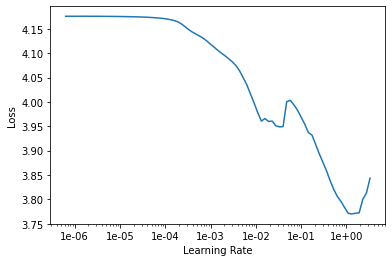

In [11]:
learn.lr_find()
learn.recorder.plot()

In [12]:
learn.fit_one_cycle(5, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time


/home/justin/anaconda3/envs/dnabert_distill/lib/python3.8/site-packages/torch/nn/modules/module.py:1504: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  if p.grad is not None:
/home/justin/anaconda3/envs/dnabert_distill/lib/python3.8/site-packages/torch/nn/modules/module.py:1504: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See gi

In [ ]:
learn.save('b1_3m1s')

In [ ]:
learn.save_encoder('b1_3m1s_enc')

In [ ]:
import torch

print(torch.cuda.is_available())


print(torch.cuda.device_count())

print(torch.cuda.current_device())


print(torch.cuda.device(0))


print(torch.cuda.get_device_name(0))


False
0


AssertionError: Torch not compiled with CUDA enabled

In [ ]:
from __future__ import print_function

# Unlike the rest of the PyTorch this file must be python2 compliant.
# This script outputs relevant system environment info
# Run it with `python collect_env.py`.
import datetime
import locale
import re
import subprocess
import sys
import os
from collections import namedtuple


try:
    import torch
    TORCH_AVAILABLE = True
except (ImportError, NameError, AttributeError, OSError):
    TORCH_AVAILABLE = False

# System Environment Information
SystemEnv = namedtuple('SystemEnv', [
    'torch_version',
    'is_debug_build',
    'cuda_compiled_version',
    'gcc_version',
    'clang_version',
    'cmake_version',
    'os',
    'libc_version',
    'python_version',
    'python_platform',
    'is_cuda_available',
    'cuda_runtime_version',
    'nvidia_driver_version',
    'nvidia_gpu_models',
    'cudnn_version',
    'pip_version',  # 'pip' or 'pip3'
    'pip_packages',
    'conda_packages',
    'hip_compiled_version',
    'hip_runtime_version',
    'miopen_runtime_version',
    'caching_allocator_config',
    'is_xnnpack_available',
])


def run(command):
    """Returns (return-code, stdout, stderr)"""
    p = subprocess.Popen(command, stdout=subprocess.PIPE,
                         stderr=subprocess.PIPE, shell=True)
    raw_output, raw_err = p.communicate()
    rc = p.returncode
    if get_platform() == 'win32':
        enc = 'oem'
    else:
        enc = locale.getpreferredencoding()
    output = raw_output.decode(enc)
    err = raw_err.decode(enc)
    return rc, output.strip(), err.strip()


def run_and_read_all(run_lambda, command):
    """Runs command using run_lambda; reads and returns entire output if rc is 0"""
    rc, out, _ = run_lambda(command)
    if rc != 0:
        return None
    return out


def run_and_parse_first_match(run_lambda, command, regex):
    """Runs command using run_lambda, returns the first regex match if it exists"""
    rc, out, _ = run_lambda(command)
    if rc != 0:
        return None
    match = re.search(regex, out)
    if match is None:
        return None
    return match.group(1)

def run_and_return_first_line(run_lambda, command):
    """Runs command using run_lambda and returns first line if output is not empty"""
    rc, out, _ = run_lambda(command)
    if rc != 0:
        return None
    return out.split('\n')[0]


def get_conda_packages(run_lambda):
    conda = os.environ.get('CONDA_EXE', 'conda')
    out = run_and_read_all(run_lambda, "{} list".format(conda))
    if out is None:
        return out

    return "\n".join(
        line
        for line in out.splitlines()
        if not line.startswith("#")
        and any(
            name in line
            for name in {
                "torch",
                "numpy",
                "cudatoolkit",
                "soumith",
                "mkl",
                "magma",
                "mkl",
            }
        )
    )

def get_gcc_version(run_lambda):
    return run_and_parse_first_match(run_lambda, 'gcc --version', r'gcc (.*)')

def get_clang_version(run_lambda):
    return run_and_parse_first_match(run_lambda, 'clang --version', r'clang version (.*)')


def get_cmake_version(run_lambda):
    return run_and_parse_first_match(run_lambda, 'cmake --version', r'cmake (.*)')


def get_nvidia_driver_version(run_lambda):
    if get_platform() == 'darwin':
        cmd = 'kextstat | grep -i cuda'
        return run_and_parse_first_match(run_lambda, cmd,
                                         r'com[.]nvidia[.]CUDA [(](.*?)[)]')
    smi = get_nvidia_smi()
    return run_and_parse_first_match(run_lambda, smi, r'Driver Version: (.*?) ')


def get_gpu_info(run_lambda):
    if get_platform() == 'darwin' or (TORCH_AVAILABLE and hasattr(torch.version, 'hip') and torch.version.hip is not None):
        if TORCH_AVAILABLE and torch.cuda.is_available():
            return torch.cuda.get_device_name(None)
        return None
    smi = get_nvidia_smi()
    uuid_regex = re.compile(r' \(UUID: .+?\)')
    rc, out, _ = run_lambda(smi + ' -L')
    if rc != 0:
        return None
    # Anonymize GPUs by removing their UUID
    return re.sub(uuid_regex, '', out)


def get_running_cuda_version(run_lambda):
    return run_and_parse_first_match(run_lambda, 'nvcc --version', r'release .+ V(.*)')


def get_cudnn_version(run_lambda):
    """This will return a list of libcudnn.so; it's hard to tell which one is being used"""
    if get_platform() == 'win32':
        system_root = os.environ.get('SYSTEMROOT', 'C:\\Windows')
        cuda_path = os.environ.get('CUDA_PATH', "%CUDA_PATH%")
        where_cmd = os.path.join(system_root, 'System32', 'where')
        cudnn_cmd = '{} /R "{}\\bin" cudnn*.dll'.format(where_cmd, cuda_path)
    elif get_platform() == 'darwin':
        # CUDA libraries and drivers can be found in /usr/local/cuda/. See
        # https://docs.nvidia.com/cuda/cuda-installation-guide-mac-os-x/index.html#install
        # https://docs.nvidia.com/deeplearning/sdk/cudnn-install/index.html#installmac
        # Use CUDNN_LIBRARY when cudnn library is installed elsewhere.
        cudnn_cmd = 'ls /usr/local/cuda/lib/libcudnn*'
    else:
        cudnn_cmd = 'ldconfig -p | grep libcudnn | rev | cut -d" " -f1 | rev'
    rc, out, _ = run_lambda(cudnn_cmd)
    # find will return 1 if there are permission errors or if not found
    if len(out) == 0 or (rc != 1 and rc != 0):
        l = os.environ.get('CUDNN_LIBRARY')
        if l is not None and os.path.isfile(l):
            return os.path.realpath(l)
        return None
    files_set = set()
    for fn in out.split('\n'):
        fn = os.path.realpath(fn)  # eliminate symbolic links
        if os.path.isfile(fn):
            files_set.add(fn)
    if not files_set:
        return None
    # Alphabetize the result because the order is non-deterministic otherwise
    files = list(sorted(files_set))
    if len(files) == 1:
        return files[0]
    result = '\n'.join(files)
    return 'Probably one of the following:\n{}'.format(result)


def get_nvidia_smi():
    # Note: nvidia-smi is currently available only on Windows and Linux
    smi = 'nvidia-smi'
    if get_platform() == 'win32':
        system_root = os.environ.get('SYSTEMROOT', 'C:\\Windows')
        program_files_root = os.environ.get('PROGRAMFILES', 'C:\\Program Files')
        legacy_path = os.path.join(program_files_root, 'NVIDIA Corporation', 'NVSMI', smi)
        new_path = os.path.join(system_root, 'System32', smi)
        smis = [new_path, legacy_path]
        for candidate_smi in smis:
            if os.path.exists(candidate_smi):
                smi = '"{}"'.format(candidate_smi)
                break
    return smi


def get_platform():
    if sys.platform.startswith('linux'):
        return 'linux'
    elif sys.platform.startswith('win32'):
        return 'win32'
    elif sys.platform.startswith('cygwin'):
        return 'cygwin'
    elif sys.platform.startswith('darwin'):
        return 'darwin'
    else:
        return sys.platform


def get_mac_version(run_lambda):
    return run_and_parse_first_match(run_lambda, 'sw_vers -productVersion', r'(.*)')


def get_windows_version(run_lambda):
    system_root = os.environ.get('SYSTEMROOT', 'C:\\Windows')
    wmic_cmd = os.path.join(system_root, 'System32', 'Wbem', 'wmic')
    findstr_cmd = os.path.join(system_root, 'System32', 'findstr')
    return run_and_read_all(run_lambda, '{} os get Caption | {} /v Caption'.format(wmic_cmd, findstr_cmd))


def get_lsb_version(run_lambda):
    return run_and_parse_first_match(run_lambda, 'lsb_release -a', r'Description:\t(.*)')


def check_release_file(run_lambda):
    return run_and_parse_first_match(run_lambda, 'cat /etc/*-release',
                                     r'PRETTY_NAME="(.*)"')


def get_os(run_lambda):
    from platform import machine
    platform = get_platform()

    if platform == 'win32' or platform == 'cygwin':
        return get_windows_version(run_lambda)

    if platform == 'darwin':
        version = get_mac_version(run_lambda)
        if version is None:
            return None
        return 'macOS {} ({})'.format(version, machine())

    if platform == 'linux':
        # Ubuntu/Debian based
        desc = get_lsb_version(run_lambda)
        if desc is not None:
            return '{} ({})'.format(desc, machine())

        # Try reading /etc/*-release
        desc = check_release_file(run_lambda)
        if desc is not None:
            return '{} ({})'.format(desc, machine())

        return '{} ({})'.format(platform, machine())

    # Unknown platform
    return platform


def get_python_platform():
    import platform
    return platform.platform()


def get_libc_version():
    import platform
    if get_platform() != 'linux':
        return 'N/A'
    return '-'.join(platform.libc_ver())


def get_pip_packages(run_lambda):
    """Returns `pip list` output. Note: will also find conda-installed pytorch
    and numpy packages."""
    # People generally have `pip` as `pip` or `pip3`
    # But here it is incoved as `python -mpip`
    def run_with_pip(pip):
        out = run_and_read_all(run_lambda, "{} list --format=freeze".format(pip))
        return "\n".join(
            line
            for line in out.splitlines()
            if any(
                name in line
                for name in {
                    "torch",
                    "numpy",
                    "mypy",
                }
            )
        )

    pip_version = 'pip3' if sys.version[0] == '3' else 'pip'
    out = run_with_pip(sys.executable + ' -mpip')

    return pip_version, out


def get_cachingallocator_config():
    ca_config = os.environ.get('PYTORCH_CUDA_ALLOC_CONF', '')
    return ca_config

def is_xnnpack_available():
    if TORCH_AVAILABLE:
        import torch.backends.xnnpack
        return str(torch.backends.xnnpack.enabled)  # type: ignore[attr-defined]
    else:
        return "N/A"

def get_env_info():
    run_lambda = run
    pip_version, pip_list_output = get_pip_packages(run_lambda)

    if TORCH_AVAILABLE:
        version_str = torch.__version__
        debug_mode_str = str(torch.version.debug)
        cuda_available_str = str(torch.cuda.is_available())
        cuda_version_str = torch.version.cuda
        if not hasattr(torch.version, 'hip') or torch.version.hip is None:  # cuda version
            hip_compiled_version = hip_runtime_version = miopen_runtime_version = 'N/A'
        else:  # HIP version
            cfg = torch._C._show_config().split('\n')
            hip_runtime_version = [s.rsplit(None, 1)[-1] for s in cfg if 'HIP Runtime' in s][0]
            miopen_runtime_version = [s.rsplit(None, 1)[-1] for s in cfg if 'MIOpen' in s][0]
            cuda_version_str = 'N/A'
            hip_compiled_version = torch.version.hip
    else:
        version_str = debug_mode_str = cuda_available_str = cuda_version_str = 'N/A'
        hip_compiled_version = hip_runtime_version = miopen_runtime_version = 'N/A'

    sys_version = sys.version.replace("\n", " ")

    return SystemEnv(
        torch_version=version_str,
        is_debug_build=debug_mode_str,
        python_version='{} ({}-bit runtime)'.format(sys_version, sys.maxsize.bit_length() + 1),
        python_platform=get_python_platform(),
        is_cuda_available=cuda_available_str,
        cuda_compiled_version=cuda_version_str,
        cuda_runtime_version=get_running_cuda_version(run_lambda),
        nvidia_gpu_models=get_gpu_info(run_lambda),
        nvidia_driver_version=get_nvidia_driver_version(run_lambda),
        cudnn_version=get_cudnn_version(run_lambda),
        hip_compiled_version=hip_compiled_version,
        hip_runtime_version=hip_runtime_version,
        miopen_runtime_version=miopen_runtime_version,
        pip_version=pip_version,
        pip_packages=pip_list_output,
        conda_packages=get_conda_packages(run_lambda),
        os=get_os(run_lambda),
        libc_version=get_libc_version(),
        gcc_version=get_gcc_version(run_lambda),
        clang_version=get_clang_version(run_lambda),
        cmake_version=get_cmake_version(run_lambda),
        caching_allocator_config=get_cachingallocator_config(),
        is_xnnpack_available=is_xnnpack_available(),
    )

env_info_fmt = """
PyTorch version: {torch_version}
Is debug build: {is_debug_build}
CUDA used to build PyTorch: {cuda_compiled_version}
ROCM used to build PyTorch: {hip_compiled_version}

OS: {os}
GCC version: {gcc_version}
Clang version: {clang_version}
CMake version: {cmake_version}
Libc version: {libc_version}

Python version: {python_version}
Python platform: {python_platform}
Is CUDA available: {is_cuda_available}
CUDA runtime version: {cuda_runtime_version}
GPU models and configuration: {nvidia_gpu_models}
Nvidia driver version: {nvidia_driver_version}
cuDNN version: {cudnn_version}
HIP runtime version: {hip_runtime_version}
MIOpen runtime version: {miopen_runtime_version}
Is XNNPACK available: {is_xnnpack_available}

Versions of relevant libraries:
{pip_packages}
{conda_packages}
""".strip()


def pretty_str(envinfo):
    def replace_nones(dct, replacement='Could not collect'):
        for key in dct.keys():
            if dct[key] is not None:
                continue
            dct[key] = replacement
        return dct

    def replace_bools(dct, true='Yes', false='No'):
        for key in dct.keys():
            if dct[key] is True:
                dct[key] = true
            elif dct[key] is False:
                dct[key] = false
        return dct

    def prepend(text, tag='[prepend]'):
        lines = text.split('\n')
        updated_lines = [tag + line for line in lines]
        return '\n'.join(updated_lines)

    def replace_if_empty(text, replacement='No relevant packages'):
        if text is not None and len(text) == 0:
            return replacement
        return text

    def maybe_start_on_next_line(string):
        # If `string` is multiline, prepend a \n to it.
        if string is not None and len(string.split('\n')) > 1:
            return '\n{}\n'.format(string)
        return string

    mutable_dict = envinfo._asdict()

    # If nvidia_gpu_models is multiline, start on the next line
    mutable_dict['nvidia_gpu_models'] = \
        maybe_start_on_next_line(envinfo.nvidia_gpu_models)

    # If the machine doesn't have CUDA, report some fields as 'No CUDA'
    dynamic_cuda_fields = [
        'cuda_runtime_version',
        'nvidia_gpu_models',
        'nvidia_driver_version',
    ]
    all_cuda_fields = dynamic_cuda_fields + ['cudnn_version']
    all_dynamic_cuda_fields_missing = all(
        mutable_dict[field] is None for field in dynamic_cuda_fields)
    if TORCH_AVAILABLE and not torch.cuda.is_available() and all_dynamic_cuda_fields_missing:
        for field in all_cuda_fields:
            mutable_dict[field] = 'No CUDA'
        if envinfo.cuda_compiled_version is None:
            mutable_dict['cuda_compiled_version'] = 'None'

    # Replace True with Yes, False with No
    mutable_dict = replace_bools(mutable_dict)

    # Replace all None objects with 'Could not collect'
    mutable_dict = replace_nones(mutable_dict)

    # If either of these are '', replace with 'No relevant packages'
    mutable_dict['pip_packages'] = replace_if_empty(mutable_dict['pip_packages'])
    mutable_dict['conda_packages'] = replace_if_empty(mutable_dict['conda_packages'])

    # Tag conda and pip packages with a prefix
    # If they were previously None, they'll show up as ie '[conda] Could not collect'
    if mutable_dict['pip_packages']:
        mutable_dict['pip_packages'] = prepend(mutable_dict['pip_packages'],
                                               '[{}] '.format(envinfo.pip_version))
    if mutable_dict['conda_packages']:
        mutable_dict['conda_packages'] = prepend(mutable_dict['conda_packages'],
                                                 '[conda] ')
    return env_info_fmt.format(**mutable_dict)


def get_pretty_env_info():
    return pretty_str(get_env_info())


def main():
    print("Collecting environment information...")
    output = get_pretty_env_info()
    print(output)

    if TORCH_AVAILABLE and hasattr(torch, 'utils') and hasattr(torch.utils, '_crash_handler'):
        minidump_dir = torch.utils._crash_handler.DEFAULT_MINIDUMP_DIR
        if sys.platform == "linux" and os.path.exists(minidump_dir):
            dumps = [os.path.join(minidump_dir, dump) for dump in os.listdir(minidump_dir)]
            latest = max(dumps, key=os.path.getctime)
            ctime = os.path.getctime(latest)
            creation_time = datetime.datetime.fromtimestamp(ctime).strftime('%Y-%m-%d %H:%M:%S')
            msg = "\n*** Detected a minidump at {} created on {}, ".format(latest, creation_time) + \
                  "if this is related to your bug please include it when you file a report ***"
            print(msg, file=sys.stderr)



if __name__ == '__main__':
    main()

PyTorch version: 1.12.0
Is debug build: False
CUDA used to build PyTorch: Could not collect
ROCM used to build PyTorch: N/A

OS: Ubuntu 22.04 LTS (x86_64)
GCC version: (Ubuntu 11.2.0-19ubuntu1) 11.2.0
Clang version: Could not collect
CMake version: version 3.23.3
Libc version: glibc-2.35

Python version: 3.8.13 | packaged by conda-forge | (default, Mar 25 2022, 06:04:18)  [GCC 10.3.0] (64-bit runtime)
Python platform: Linux-5.10.102.1-microsoft-standard-WSL2-x86_64-with-glibc2.10
Is CUDA available: False
CUDA runtime version: Could not collect
GPU models and configuration: GPU 0: NVIDIA GeForce GTX 1650 SUPER
Nvidia driver version: 525.14
cuDNN version: Could not collect
HIP runtime version: N/A
MIOpen runtime version: N/A
Is XNNPACK available: True

Versions of relevant libraries:
[pip3] numpy==1.19.2
[pip3] torch==1.12.0
[pip3] torchaudio==0.12.0
[pip3] torchvision==0.13.0
[conda] _tflow_select             2.3.0                       mkl  
[conda] blas                      2.115     

In [ ]:
import torch
torch.zeros(1).cuda()

tensor([0.], device='cuda:0')